In [1]:
#pip install scikit-image

In [2]:
file_data = '../data/example_ground_truth.csv'
path_image = '../data/example_image'
path_mask = '../data/example_segmentation'
path_processed = "../processed/"

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
from math import pi
from math import sqrt
from skimage import morphology
from skimage.morphology import opening
from skimage import transform
from skimage import filters
from skimage.filters import sobel
from PIL import Image

In [4]:
img_path = '../data/example_image/'
seg_path = '../data/example_segmentation/'

truth = '../data/example_ground_truth.csv'
features = '../features/features.csv'

file_data = '../data/example_ground_truth.csv'
path_image = '../data/example_image'
path_mask = '../data/example_segmentation'
path_processed = "../processed/"

In [5]:
def boundaries(image):
    mask = np.where(image == 1)
    left = min(mask[1])
    right = max(mask[1])
    upper = min(mask[0])
    lower = max(mask[0])
    return upper, lower, left, right

def center(image):
    up, dw, lt, rt = boundaries(image)
    center = ((up + dw)//2,(rt + lt)//2)
    return center

(2016, 3024, 3)
uint8
(2016, 3024)


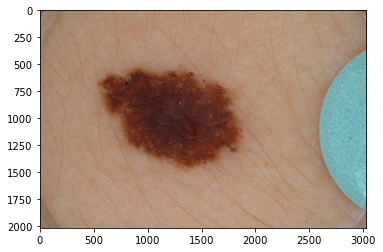

In [6]:
img = plt.imread(img_path + "ISIC_0003582.jpg")
mask = plt.imread('../data/example_segmentation/ISIC_0001769_segmentation.png')

print(img.shape)
print(img.dtype)
print(mask.shape)

plt.imshow(img, cmap='gray');

In [7]:
#From TA Camilla
#Measure area: the sum of all white pixels in the mask image

area = np.sum(mask)

#Measure perimeter: first find which pixels belong to the perimeter.

struct_element = morphology.disk(1)
mask_erotion = morphology.binary_erosion(mask, struct_element)
image_perimeter = mask - mask_erotion

#simple
width_max = 0
height_max = 0

for row in image_perimeter:
    result = np.where(row==1)[0]
    if result.size != 0:
        width_diff = result[-1] - result[0]
        if width_diff > width_max:
            width_max = width_diff
            
for col in image_perimeter.transpose():
    result = np.where(col == 1)[0]
    if result.size != 0:
        height_diff = result[-1] - result[0]
        if height_diff > height_max:
            height_max = height_diff


In [8]:
print("width_max:", width_max)
print("height_max:", height_max)

width_max: 654
height_max: 480


In [9]:
print(boundaries(img))
print(center(img))

(607, 1398, 619, 1739)
(1002, 1179)


### Exploring the Data

In [10]:
#How much do we loose if we remove the cases of the other disease
data = pd.read_csv(file_data)
data
#Create a list over all the images in the dataset
image_id = list(data['image_id'])
mask = (data["seborrheic_keratosis"] == 0)
data.shape[0] - data[mask].shape[0]


42

In [11]:
file_data = '../data/example_ground_truth.csv'
file_features = '../features/features.csv'

df = pd.read_csv(file_data)
features = pd.read_csv(file_features)


# Combine variables we want in one place
df = df.drop(['image_id','seborrheic_keratosis'],axis=1)
df['area'] = features['area']
df['perimeter'] = features['perimeter']

print(df.head)

<bound method NDFrame.head of      melanoma        area  perimeter
0         0.0    216160.0     2013.0
1         0.0    130493.0     1372.0
2         0.0    205116.0     1720.0
3         0.0    161705.0     1344.0
4         0.0    317040.0     2063.0
..        ...         ...        ...
145       0.0   9732988.0    13775.0
146       0.0  12049938.0    19517.0
147       0.0   8856478.0    13813.0
148       0.0   8951522.0    13742.0
149       0.0   3193093.0     8751.0

[150 rows x 3 columns]>


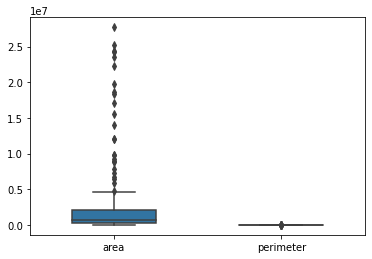

In [12]:
import seaborn as sns

df1 = df[['area','perimeter']]
sns.boxplot(data=df1, width=0.5)


3.552713678800501e-17
1.0


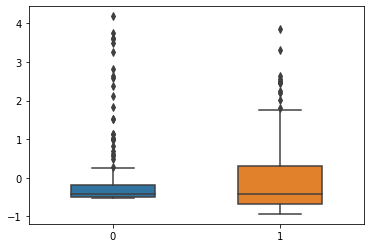

In [13]:
# Let's scale the features
from sklearn import preprocessing

#Fit scaler on our data
scaler = preprocessing.StandardScaler().fit(df1)

#Apply to data itself
df2 = scaler.transform(df1)

print(df2.mean()) #small number close to 0, round of error
print(df2.var())  #equal to 1 
sns.boxplot(data=df2, width=0.5,fliersize=5) #we see both negative and positive values, since the mean is 0

In [14]:
#print(df2.dtype) #scaler lost df information :(
#df2 = pd.DataFrame(df2,columns=['area','perimeter'])

# Look at values per class
df2['melanoma'] = df['melanoma']
sns.pairplot(df2, hue="melanoma", size=3,diag_kind="hist")

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
ax = sns.violinplot(x="melanoma", y="area", data=df2,size=8)

In [ ]:
# Split the data before feature selection
from sklearn.model_selection import train_test_split

# Some noisy data not correlated
noise = np.random.RandomState(42).uniform(0, 0.1, size=(df2.shape[0], 20))

# Add the noisy data to the informative features
X = np.hstack((df2[['area', 'perimeter']], noise))
y = df2['melanoma']

# Split dataset to select feature and evaluate the classifier
X_dev, X_test, y_dev, y_test = train_test_split(
        X, y, stratify=y, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(
        X_dev, y_dev, stratify=y_dev)